In [1]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


In [2]:
train = pd.read_csv("/content/drive/MyDrive/DeepLearningProject/train.csv")

In [3]:
train.dropna(subset = ["text"], inplace=True)

In [4]:
train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [5]:
#Let's get the dataset lenght
len(train)

27480

In [6]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [7]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11117,11117,11111
positive,8582,8582,5537


In [8]:
#Let's keep only the columns that we're going to use
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [9]:

#Is there any null value?
train["selected_text"].isnull().sum()

0

In [10]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),     deacc=True))

In [12]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [13]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [15]:
len(data_words)

27480

In [16]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [17]:
data = np.array(data)

In [18]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [19]:
len(labels)

27480

## Data sequencing and splitting
#### We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [20]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [21]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [22]:

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6870 20610 6870


## Model building

SimpleRNN model

In [23]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 64))
model0.add(layers.LSTM(64,dropout=0.5))
model0.add(layers.Dense(3,activation='softmax'))

print(model0.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("/content/drive/MyDrive/DeepLearningProject/TweetSentimentAnalysis/LSTM/LSTM_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint0])

Epoch 1/20
645/645 [==============================] - 86s 131ms/step - loss: 0.8064 - accuracy: 0.6385 - val_loss: 0.5378 - val_accuracy: 0.7969

Epoch 00001: val_accuracy improved from -inf to 0.79694, saving model to /content/drive/MyDrive/DeepLearningProject/TweetSentimentAnalysis/LSTM/LSTM_model0.hdf5
Epoch 2/20
645/645 [==============================] - 89s 137ms/step - loss: 0.5078 - accuracy: 0.8031 - val_loss: 0.4762 - val_accuracy: 0.8180

Epoch 00002: val_accuracy improved from 0.79694 to 0.81805, saving model to /content/drive/MyDrive/DeepLearningProject/TweetSentimentAnalysis/LSTM/LSTM_model0.hdf5
Epoch 3/20
645/645 [==============================] - 92s 143ms/step - loss: 0.4394 - accuracy: 0.8343 - val_loss: 0.4670 - val_accuracy: 0.8141

Epoch 00003: val_accuracy did not improve from 0.81805
Epoch 4/20
645/645 [==============================] - 88s 137ms/step - loss: 0.4316 - accuracy: 0.8355 - val_loss: 0.4405 - val_accuracy: 0.8348

Epoch 00004: val_accuracy improved f

In [25]:
test_loss, test_acc = model0.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 5s - loss: 0.4291 - accuracy: 0.8418
Model accuracy:  0.8417758345603943


In [26]:
predictions = model0.predict(X_test)

## CONFUSION MATRIX
Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [27]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

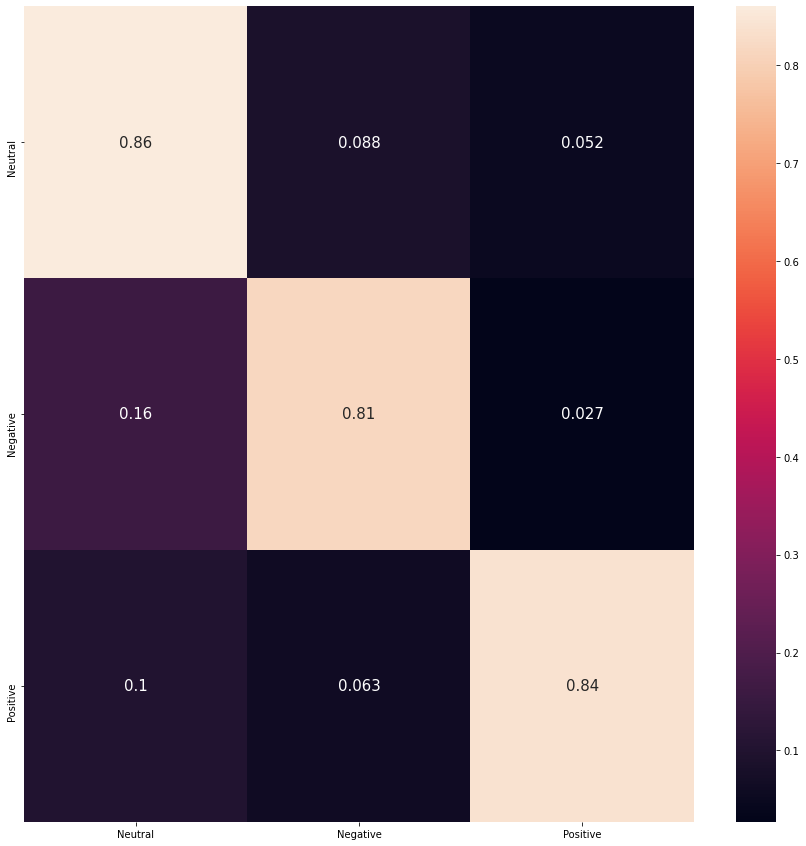

In [28]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it performs on some test text.

In [29]:
sentiment = ['Neutral','Negative','Positive']

In [30]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model0.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [31]:
sequence = tokenizer.texts_to_sequences(['this deep learning project is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model0.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [32]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model0.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [33]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model0.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'